# Partisan domain bias score analysis

This file is to analyze the partisan bias score distribution for searches of the Democratic and Republican members. 

Import the libraries

In [50]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

Import domain list and their proportions, import bias score from Ronald et al. 2018.

In [53]:
dem_rep_prop = pd.read_csv('../data/house_analysis/domain_dem_rep_prop.csv')

In [54]:
ron_news = pd.read_csv('../data/bias_score_ron_2018.csv')

Attach bias score to the domian list.

In [55]:
domain_ratings = ron_news[ron_news['domain'].isin(dem_rep_prop.domain)]

In [65]:
all_domain_leaning_prop = pd.merge(dem_rep_prop, domain_ratings[['domain', 'bias_score']].drop_duplicates(), how="left", on='domain')

In [66]:
all_domain_leaning_prop

,domain,dem_prop,rep_prop,bias_score
0,Katko,0.000000e+00,3.570443e-09,NaN
1,100e53.com,2.561136e-08,0.000000e+00,NaN
2,1011now.com,2.148793e-05,4.551387e-04,0.5387
3,101espn.com,0.000000e+00,1.553143e-06,NaN
4,1057news.com,2.845707e-09,0.000000e+00,NaN
...,...,...,...,...
8846,zimmerlaw.com,1.138283e-08,0.000000e+00,NaN
8847,zocdoc.com,8.821692e-08,0.000000e+00,NaN
8848,zoelofgren.com,2.409289e-04,0.000000e+00,NaN
8849,zoominfo.com,1.337482e-07,0.000000e+00,NaN


In [58]:
all_domain_leaning_prop.to_csv("../data/house_analysis/domain_party_proportion_with_biasscore.csv", index=False)

Calculate the rate of domains with bias score.

In [59]:
# Coverage rate
len(all_domain_leaning_prop.dropna())/len(all_domain_leaning_prop)

0.261439385380183

In [62]:
all_domain_leaning_prop_no_nan = all_domain_leaning_prop.dropna()

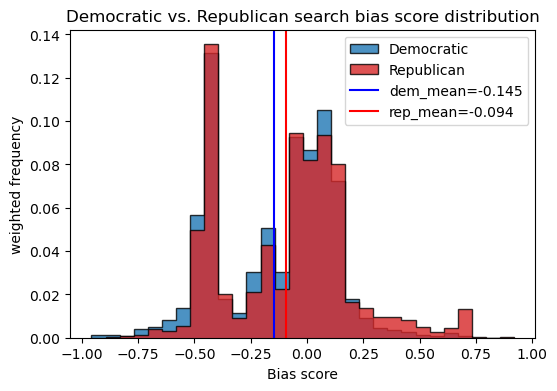

In [63]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.hist(all_domain_leaning_prop_no_nan['bias_score'], edgecolor='black', bins=30, weights=all_domain_leaning_prop_no_nan['dem_prop'], 
         histtype='step', fill=True, color='#1f77b4', label='Democratic', alpha = 0.8)
plt.hist(all_domain_leaning_prop_no_nan['bias_score'], edgecolor='black', bins=30, weights=all_domain_leaning_prop_no_nan['rep_prop'], 
         histtype='step', fill=True, color='#d62728', label='Republican', alpha = 0.8)

dem_weighted_avg = np.average(all_domain_leaning_prop_no_nan['bias_score'], weights=all_domain_leaning_prop_no_nan['dem_prop'])
plt.axvline(x = dem_weighted_avg, color = 'b',label = 'dem_mean='+str(round(dem_weighted_avg, 3)))
rep_weighted_avg = np.average(all_domain_leaning_prop_no_nan['bias_score'], weights=all_domain_leaning_prop_no_nan['rep_prop'])
plt.axvline(x = rep_weighted_avg, color = 'r',label = 'rep_mean='+str(round(rep_weighted_avg, 3)))
plt.legend()
 
plt.xlabel('Bias score')
plt.ylabel('weighted frequency')
plt.title("Democratic vs. Republican search bias score distribution")
plt.savefig("../data/plots/dem_rep_bias_score_dist.png", bbox_inches='tight', dpi=200) 
plt.show()

## Stats test on the difference between distribution for all type domains

In [20]:
# define weighted ks test
# code from https://stackoverflow.com/questions/40044375/how-to-calculate-the-kolmogorov-smirnov-statistic-between-two-weighted-samples
from scipy.stats import distributions

def ks_weighted(data1, data2, wei1, wei2, alternative='two-sided'):
    ix1 = np.argsort(data1)
    ix2 = np.argsort(data2)
    data1 = data1[ix1]
    data2 = data2[ix2]
    wei1 = wei1[ix1]
    wei2 = wei2[ix2]
    data = np.concatenate([data1, data2])
    cwei1 = np.hstack([0, np.cumsum(wei1)/sum(wei1)])
    cwei2 = np.hstack([0, np.cumsum(wei2)/sum(wei2)])
    cdf1we = cwei1[np.searchsorted(data1, data, side='right')]
    cdf2we = cwei2[np.searchsorted(data2, data, side='right')]
    d = np.max(np.abs(cdf1we - cdf2we))
    # calculate p-value
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    m, n = sorted([float(n1), float(n2)], reverse=True)
    en = m * n / (m + n)
    if alternative == 'two-sided':
        prob = distributions.kstwo.sf(d, np.round(en))
    else:
        z = np.sqrt(en) * d
        # Use Hodges' suggested approximation Eqn 5.3
        # Requires m to be the larger of (n1, n2)
        expt = -2 * z**2 - 2 * z * (m + 2*n)/np.sqrt(m*n*(m+n))/3.0
        prob = np.exp(expt)
    return d, prob

In [68]:
bias_scores = np.array(all_domain_leaning_prop_no_nan['bias_score'])
dem_prop = np.array(all_domain_leaning_prop_no_nan['dem_prop'])
rep_prop = np.array(all_domain_leaning_prop_no_nan['rep_prop'])

d, p = ks_weighted(bias_scores, bias_scores, dem_prop, rep_prop, alternative='two-sided')

In [69]:
d, p

(np.float64(0.07286796750819358), np.float64(8.680594077609265e-06))

# News only

Import domain categories.

In [70]:
allison_cat = pd.read_csv("../data/domain_category.csv")

In [71]:
cleaned_cat = allison_cat[['domain','category']].drop_duplicates()

In [72]:
all_domain_leaning_prop_cat = pd.merge(all_domain_leaning_prop, cleaned_cat, how="left", on='domain')

In [73]:
all_domain_leaning_prop_cat

,domain,dem_prop,rep_prop,bias_score,category
0,Katko,0.000000e+00,3.570443e-09,NaN,NaN
1,100e53.com,2.561136e-08,0.000000e+00,NaN,campaign_personal
2,1011now.com,2.148793e-05,4.551387e-04,0.5387,news
3,101espn.com,0.000000e+00,1.553143e-06,NaN,news
4,1057news.com,2.845707e-09,0.000000e+00,NaN,news
...,...,...,...,...,...
8846,zimmerlaw.com,1.138283e-08,0.000000e+00,NaN,other_third_party
8847,zocdoc.com,8.821692e-08,0.000000e+00,NaN,other_third_party
8848,zoelofgren.com,2.409289e-04,0.000000e+00,NaN,campaign_personal
8849,zoominfo.com,1.337482e-07,0.000000e+00,NaN,other_third_party


In [74]:
news_leaning = all_domain_leaning_prop_cat[all_domain_leaning_prop_cat["category"]=="news"]

In [78]:
news_leaning_no_nan = news_leaning.dropna()

In [79]:
len(news_leaning_no_nan)/len(news_leaning)

0.40826482042405887

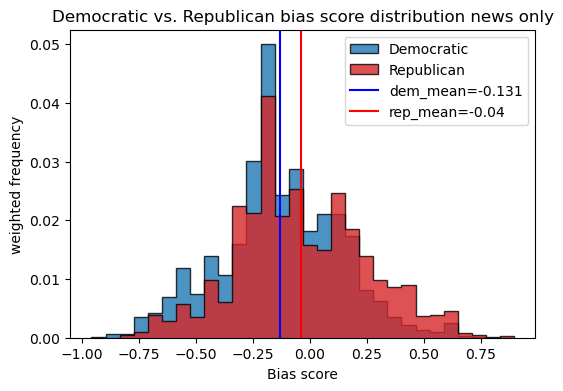

In [81]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.hist(news_leaning_no_nan['bias_score'], edgecolor='black', bins=30, weights=news_leaning_no_nan['dem_prop'], 
         histtype='step', fill=True, color='#1f77b4', label='Democratic', alpha = 0.8)
plt.hist(news_leaning_no_nan['bias_score'], edgecolor='black', bins=30, weights=news_leaning_no_nan['rep_prop'], 
         histtype='step', fill=True, color='#d62728', label='Republican', alpha = 0.8)

dem_weighted_avg = np.average(news_leaning_no_nan['bias_score'], weights=news_leaning_no_nan['dem_prop'])
plt.axvline(x = dem_weighted_avg, color = 'b',label = 'dem_mean='+str(round(dem_weighted_avg, 3)))
rep_weighted_avg = np.average(news_leaning_no_nan['bias_score'], weights=news_leaning_no_nan['rep_prop'])
plt.axvline(x = rep_weighted_avg, color = 'r',label = 'rep_mean='+str(round(rep_weighted_avg, 3)))
plt.legend()
 
plt.xlabel('Bias score')
plt.ylabel('weighted frequency')
plt.title("Democratic vs. Republican bias score distribution news only")
plt.savefig("../data/plots/dem_rep_news_bias_score_dist.png", bbox_inches='tight', dpi=200) 
plt.show()

In [84]:
bias_scores2 = np.array(news_leaning_no_nan['bias_score'])
dem_prop2 = np.array(news_leaning_no_nan['dem_prop'])
rep_prop2 = np.array(news_leaning_no_nan['rep_prop'])

d2, p2 = ks_weighted(bias_scores2, bias_scores2, dem_prop2, rep_prop2, alternative='two-sided')

In [85]:
d2, p2

(np.float64(0.13775601562331463), np.float64(4.34911167937348e-16))